# Video Games Sales Analysis


In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import kagglehub
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import f_regression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

## Data Exploration


In [30]:
video_games_sales = pd.read_csv('../data/raw/vgsales.csv')
video_games_sales.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [31]:
video_games_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


> Handle Missing Values


In [32]:
missing_data = video_games_sales.isnull().sum()
print(missing_data)

Rank              0
Name              0
Platform          0
Year            271
Genre             0
Publisher        58
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
Global_Sales      0
dtype: int64


In [33]:
video_games_sales.ffill(inplace=True)
missing_data = video_games_sales.isnull().sum()
print(missing_data)

Rank            0
Name            0
Platform        0
Year            0
Genre           0
Publisher       0
NA_Sales        0
EU_Sales        0
JP_Sales        0
Other_Sales     0
Global_Sales    0
dtype: int64


In [34]:
video_games_sales.Year = video_games_sales.Year.astype(int)

### Data Visualization


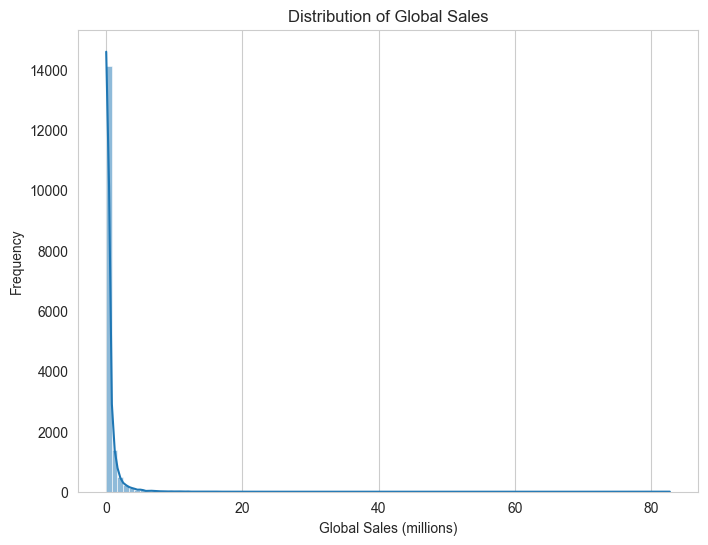

In [35]:
plt.figure(figsize=(8, 6))
sns.histplot(video_games_sales['Global_Sales'], bins=100, kde=True)
plt.title('Distribution of Global Sales')
plt.xlabel('Global Sales (millions)')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

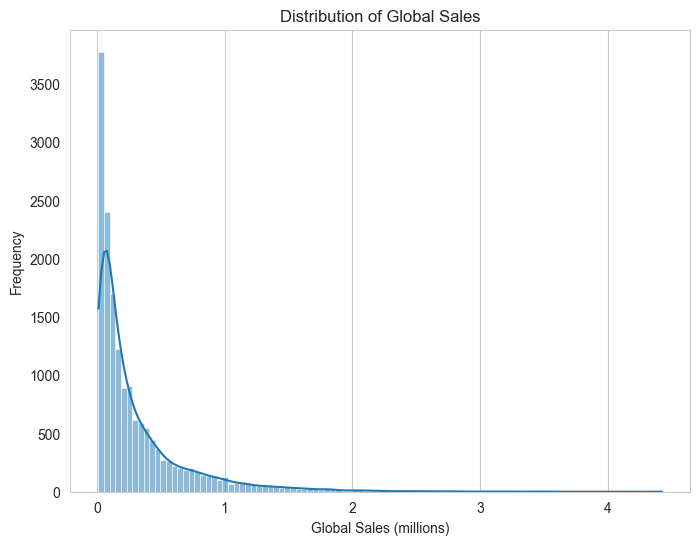

In [36]:
skewed_features = ['Global_Sales', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']
for feature in skewed_features:
    video_games_sales[feature] = np.log1p(video_games_sales[feature])
plt.figure(figsize=(8, 6))
sns.histplot(video_games_sales['Global_Sales'], bins=100, kde=True)
plt.title('Distribution of Global Sales')
plt.xlabel('Global Sales (millions)')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

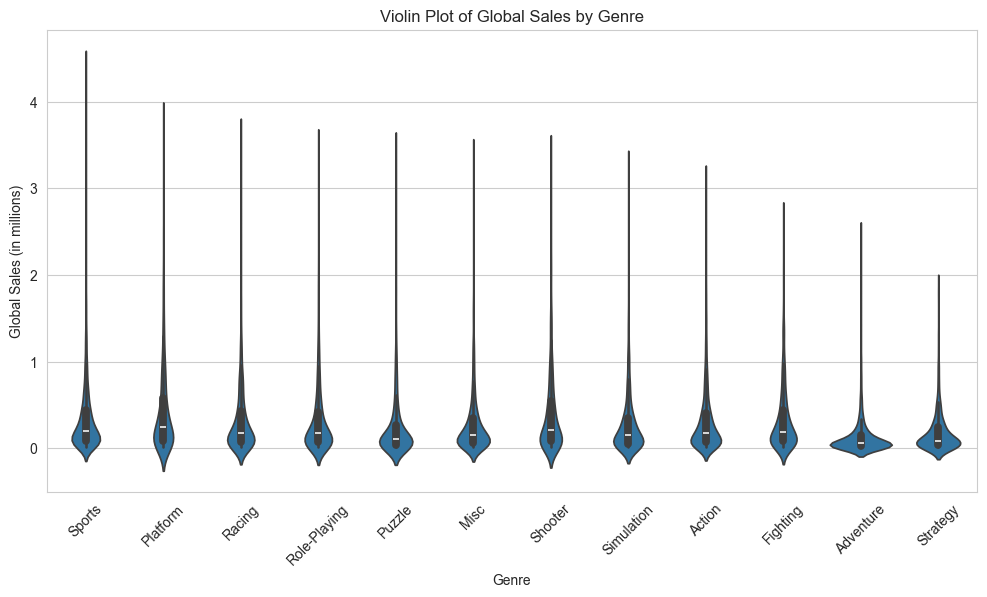

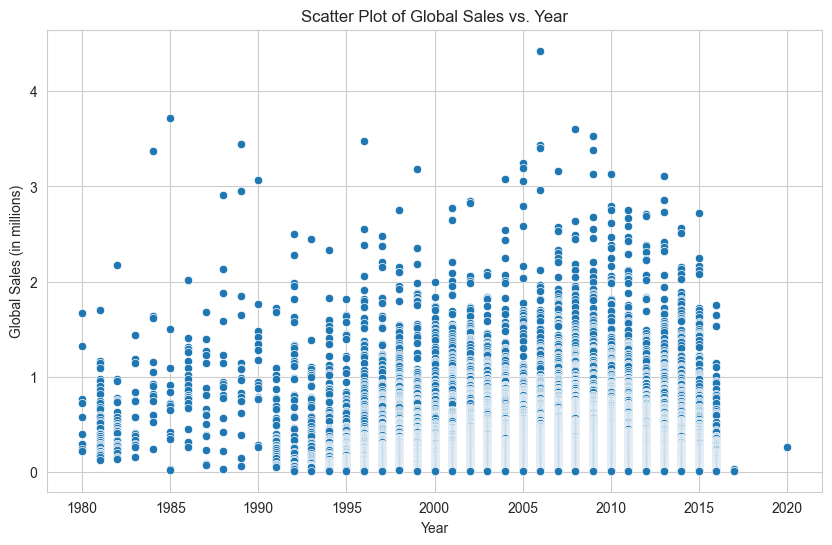

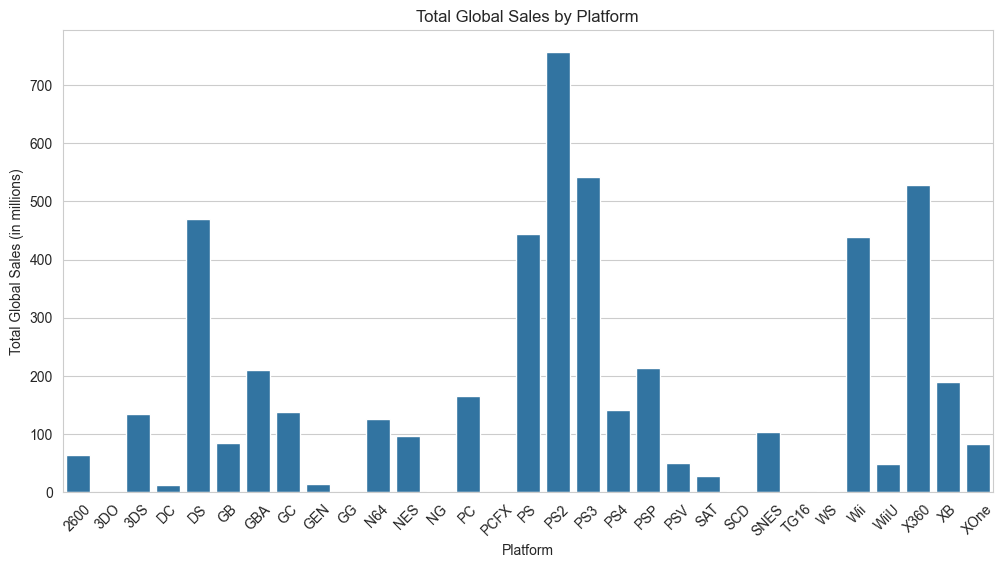

In [37]:

# Violin Plot of Global Sales by Genre
plt.figure(figsize=(12, 6))
sns.violinplot(x='Genre', y='Global_Sales', data=video_games_sales)
plt.title('Violin Plot of Global Sales by Genre')
plt.xlabel('Genre')
plt.ylabel('Global Sales (in millions)')
plt.xticks(rotation=45)
plt.show()

# Scatter Plot of Global Sales vs. Year
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Year', y='Global_Sales', data=video_games_sales)
plt.title('Scatter Plot of Global Sales vs. Year')
plt.xlabel('Year')
plt.ylabel('Global Sales (in millions)')
plt.show()

# Bar Plot of Total Sales by Platform
plt.figure(figsize=(12, 6))
platform_sales = video_games_sales.groupby('Platform')['Global_Sales'].sum().reset_index()
sns.barplot(x='Platform', y='Global_Sales', data=platform_sales)
plt.title('Total Global Sales by Platform')
plt.xlabel('Platform')
plt.ylabel('Total Global Sales (in millions)')
plt.xticks(rotation=45)
plt.show()

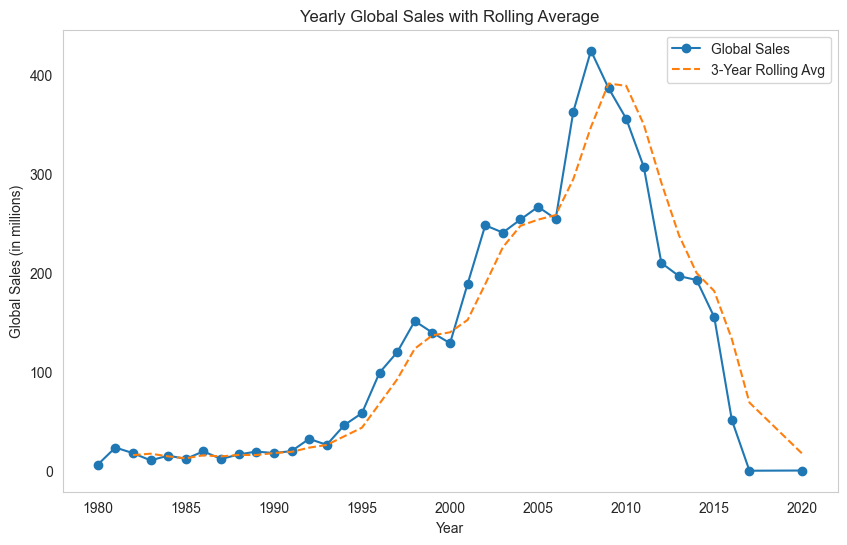

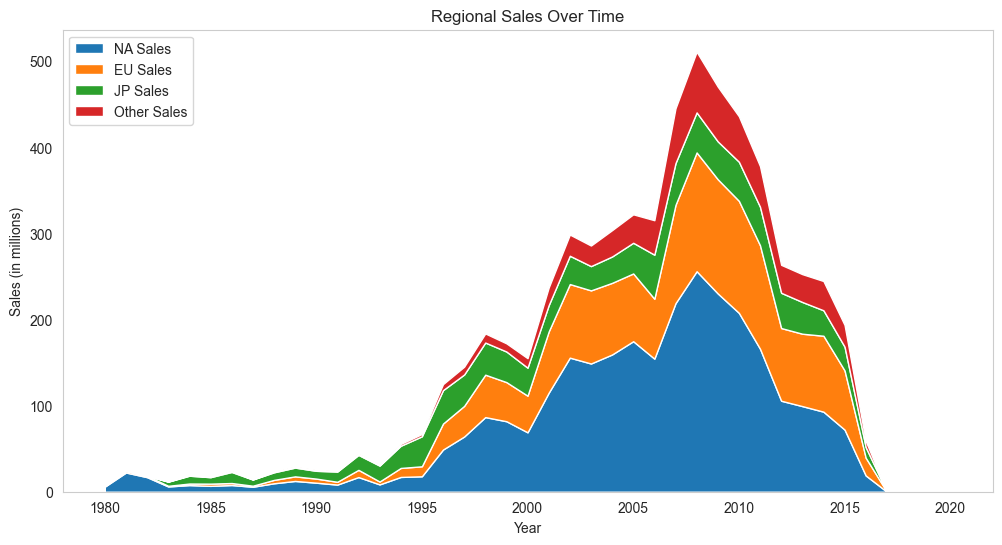

In [38]:
yearly_sales = video_games_sales.groupby('Year')['Global_Sales'].sum().reset_index()
yearly_sales['Rolling_Avg'] = yearly_sales['Global_Sales'].rolling(window=3).mean()

plt.figure(figsize=(10, 6))
plt.plot(yearly_sales['Year'], yearly_sales['Global_Sales'], marker='o', label='Global Sales')
plt.plot(yearly_sales['Year'], yearly_sales['Rolling_Avg'], label='3-Year Rolling Avg', linestyle='--')
plt.title('Yearly Global Sales with Rolling Average')
plt.xlabel('Year')
plt.ylabel('Global Sales (in millions)')
plt.grid()
plt.legend()
plt.show()

regional_sales = video_games_sales.groupby('Year')[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].sum().reset_index()
plt.figure(figsize=(12, 6))
plt.stackplot(
    regional_sales['Year'], 
    regional_sales['NA_Sales'], 
    regional_sales['EU_Sales'], 
    regional_sales['JP_Sales'], 
    regional_sales['Other_Sales'], 
    labels=['NA Sales', 'EU Sales', 'JP Sales', 'Other Sales']
)
plt.title('Regional Sales Over Time')
plt.xlabel('Year')
plt.ylabel('Sales (in millions)')
plt.legend(loc='upper left')
plt.grid()
plt.show()


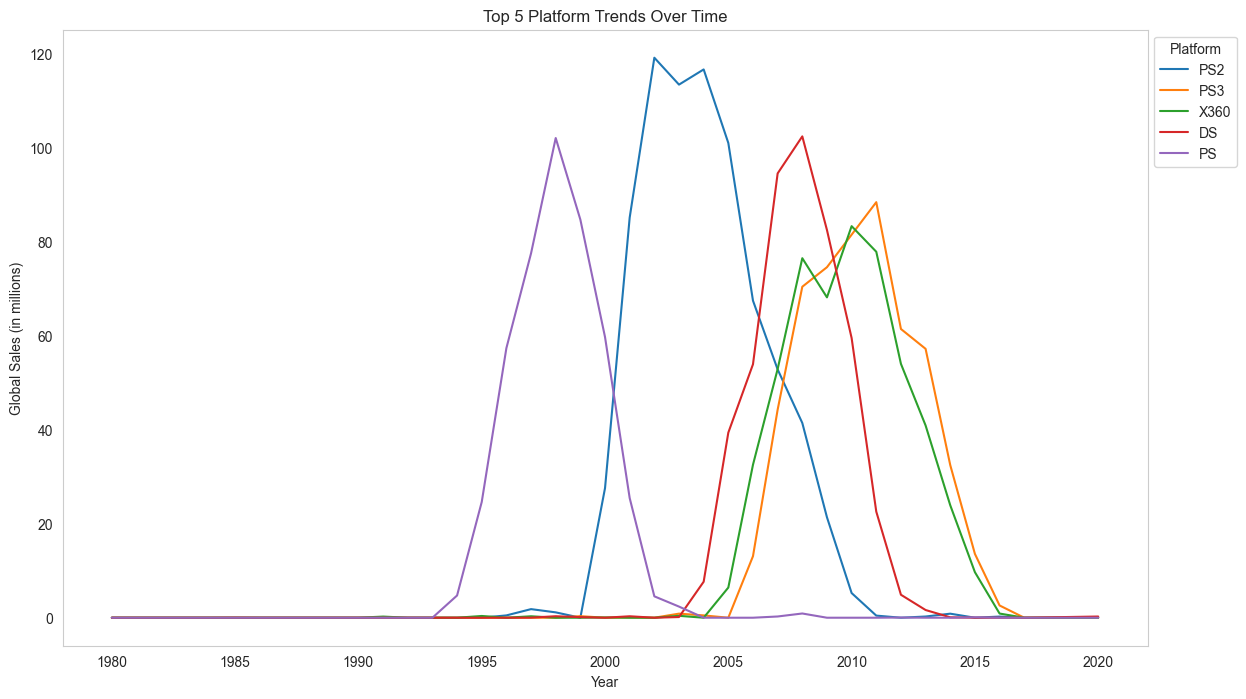

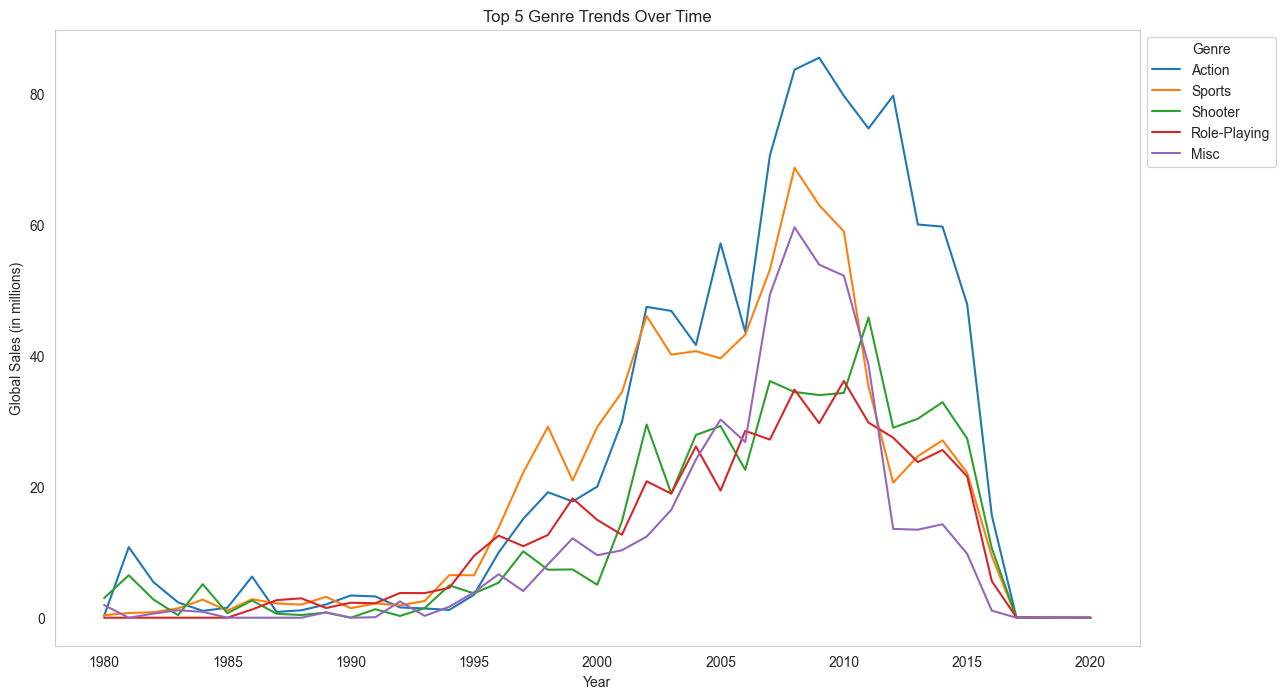

In [39]:
platform_trends = video_games_sales.groupby(['Year', 'Platform'])['Global_Sales'].sum().reset_index()
platform_pivot = platform_trends.pivot(index='Year', columns='Platform', values='Global_Sales').fillna(0)
total_sales_per_platform = platform_pivot.sum(axis=0)
top_5_platforms = total_sales_per_platform.nlargest(5).index
top_5_platform_pivot = platform_pivot[top_5_platforms]
plt.figure(figsize=(14, 8))
for platform in top_5_platform_pivot.columns:
    plt.plot(top_5_platform_pivot.index, top_5_platform_pivot[platform], label=platform)

plt.title('Top 5 Platform Trends Over Time')
plt.xlabel('Year')
plt.ylabel('Global Sales (in millions)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Platform')
plt.grid()
plt.show()

genre_trends = video_games_sales.groupby(['Year', 'Genre'])['Global_Sales'].sum().reset_index()
genre_pivot = genre_trends.pivot(index='Year', columns='Genre', values='Global_Sales').fillna(0)
total_sales_per_genre = genre_pivot.sum(axis=0)
top_5_genres = total_sales_per_genre.nlargest(5).index
top_5_genre_pivot = genre_pivot[top_5_genres]
plt.figure(figsize=(14, 8))
for genre in top_5_genre_pivot.columns:
    plt.plot(top_5_genre_pivot.index, top_5_genre_pivot[genre], label=genre)

plt.title('Top 5 Genre Trends Over Time')
plt.xlabel('Year')
plt.ylabel('Global Sales (in millions)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Genre')
plt.grid()
plt.show()

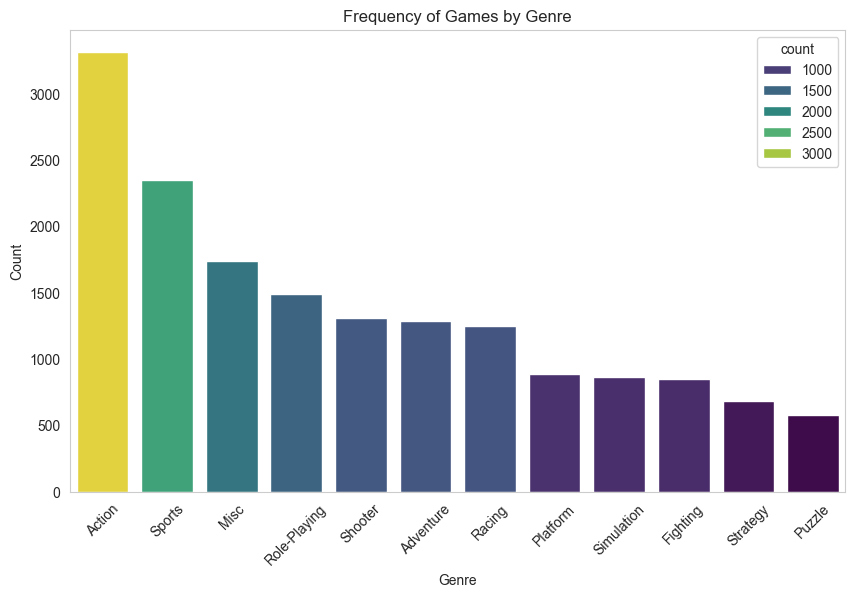

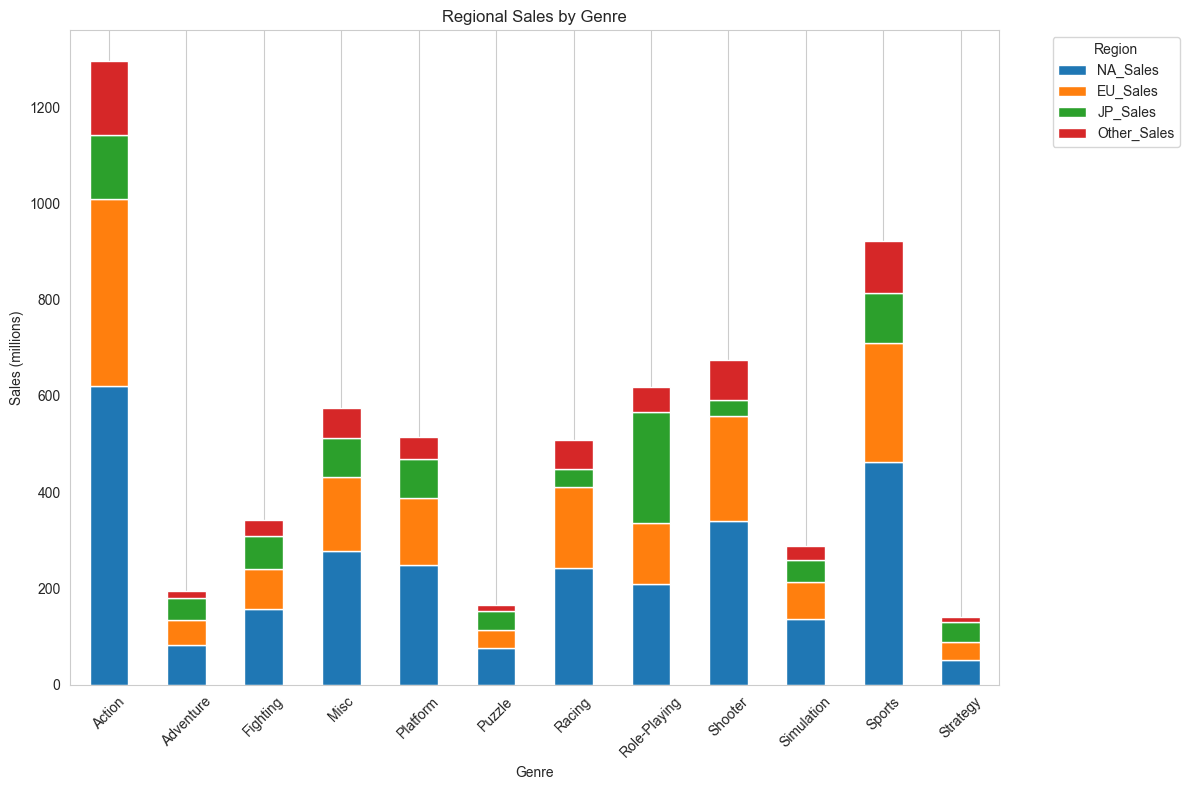

In [40]:
plt.figure(figsize=(10, 6))
genre_counts = video_games_sales['Genre'].value_counts()
sns.barplot(x=genre_counts.index, y=genre_counts.values,hue=genre_counts,palette="viridis")
plt.title('Frequency of Games by Genre')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

regional_sales = video_games_sales.groupby('Genre')[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].sum()
regional_sales.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Regional Sales by Genre')
plt.xlabel('Genre')
plt.ylabel('Sales (millions)')
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


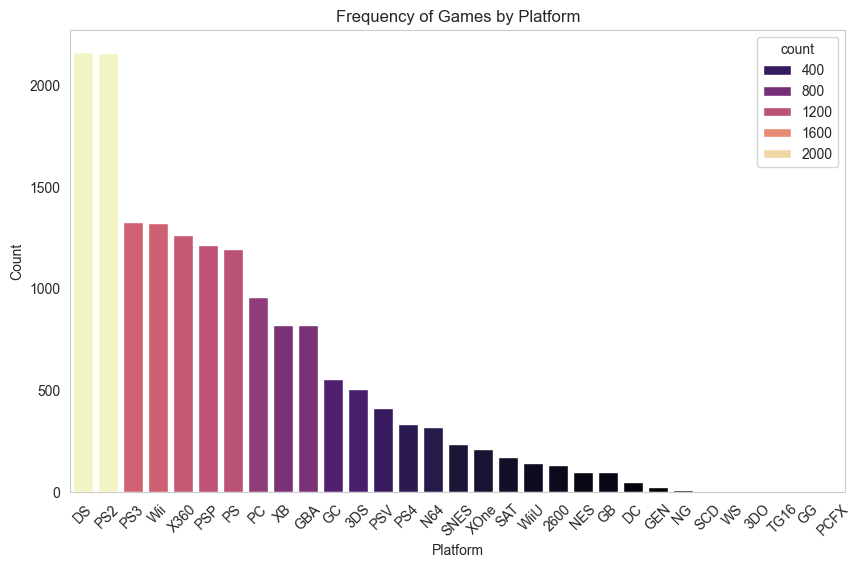

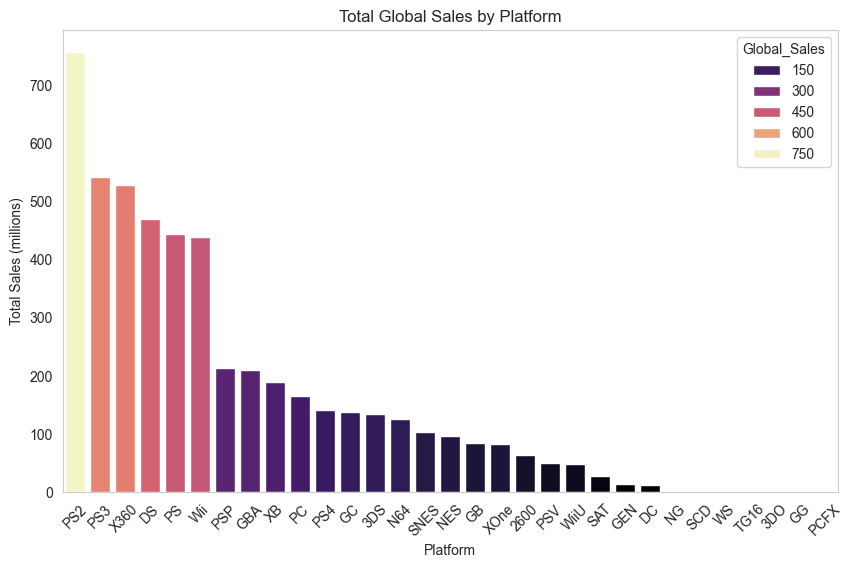

In [41]:
plt.figure(figsize=(10, 6))
platform_counts = video_games_sales['Platform'].value_counts()
sns.barplot(x=platform_counts.index, y=platform_counts.values,hue=platform_counts,palette="magma")
plt.title('Frequency of Games by Platform')
plt.xlabel('Platform')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

platform_sales = video_games_sales.groupby('Platform')['Global_Sales'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=platform_sales.index, y=platform_sales.values,hue=platform_sales,palette="magma")
plt.title('Total Global Sales by Platform')
plt.xlabel('Platform')
plt.ylabel('Total Sales (millions)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


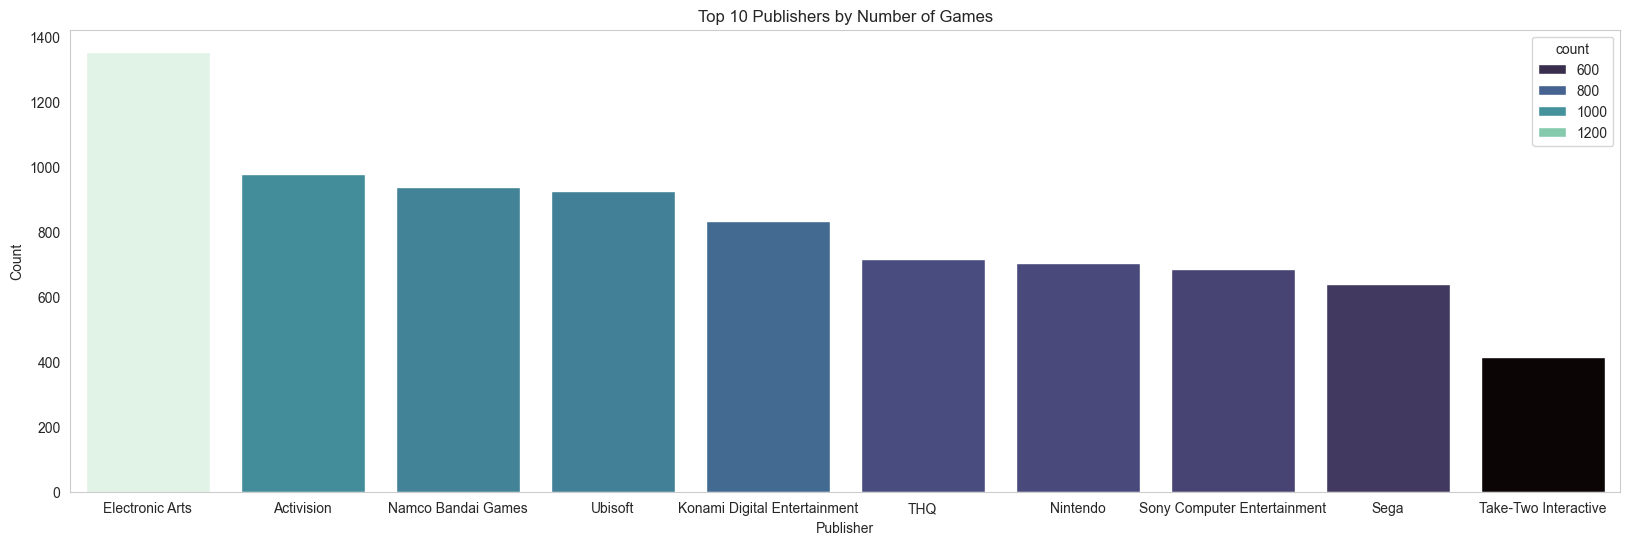

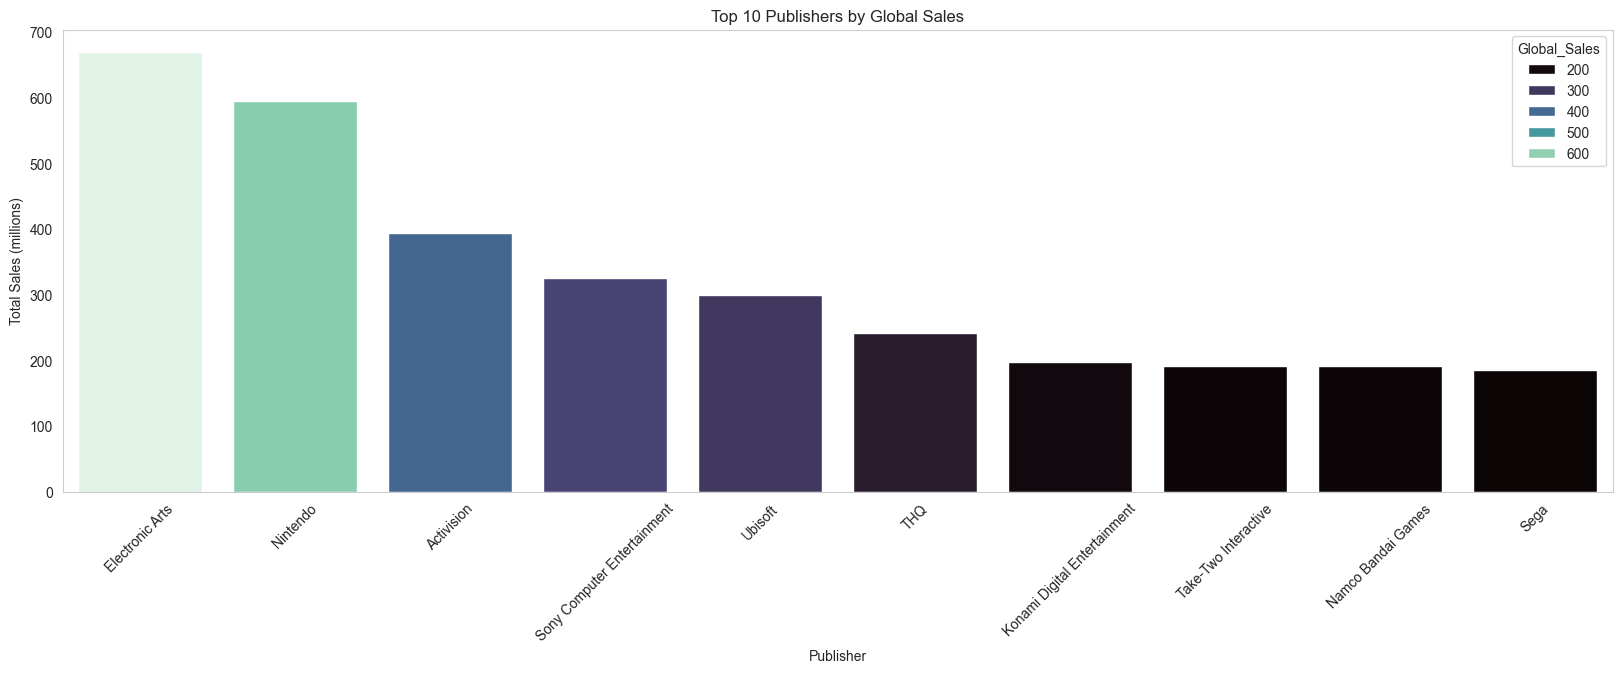

In [42]:
plt.figure(figsize=(20, 6))
publisher_counts = video_games_sales['Publisher'].value_counts().head(10)
sns.barplot(x=publisher_counts.index, y=publisher_counts.values,hue=publisher_counts,palette="mako")
plt.title('Top 10 Publishers by Number of Games')
plt.xlabel('Publisher')
plt.ylabel('Count')
plt.grid(axis='y')
plt.show()

top_publishers = video_games_sales.groupby('Publisher')['Global_Sales'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(20, 6))
sns.barplot(x=top_publishers.index, y=top_publishers.values,hue=top_publishers,palette="mako")
plt.title('Top 10 Publishers by Global Sales')
plt.xlabel('Publisher')
plt.ylabel('Total Sales (millions)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


## Regression / Classification


### Feature Selection


In [43]:
from sklearn.calibration import LabelEncoder
vgs_transformed = video_games_sales.copy()

# Label encode the 'Platform' column
label_encoder = LabelEncoder()
vgs_transformed['Platform'] = label_encoder.fit_transform(video_games_sales['Platform'])
vgs_transformed['Genre'] = label_encoder.fit_transform(video_games_sales['Genre'])
vgs_transformed['Publisher'] = label_encoder.fit_transform(video_games_sales['Publisher'])
vgs_transformed.drop(columns="Name",inplace=True)
vgs_transformed

,Rank,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,26,2006,10,359,3.749269,3.401864,1.562346,2.247072,4.427717
1,2,11,1985,4,359,3.403860,1.521699,2.055405,0.570980,3.719409
2,3,26,2008,6,359,2.824351,2.630449,1.566530,1.460938,3.606041
3,4,26,2009,10,359,2.818398,2.485740,1.453953,1.376244,3.526361
4,5,5,1996,7,359,2.507157,2.291524,2.417698,0.693147,3.477232
...,...,...,...,...,...,...,...,...,...,...
16593,16596,6,2002,4,269,0.009950,0.000000,0.000000,0.000000,0.009950
16594,16597,7,2003,8,241,0.009950,0.000000,0.000000,0.000000,0.009950
16595,16598,16,2008,6,21,0.000000,0.000000,0.000000,0.000000,0.009950
16596,16599,4,2010,5,8,0.000000,0.009950,0.000000,0.000000,0.009950


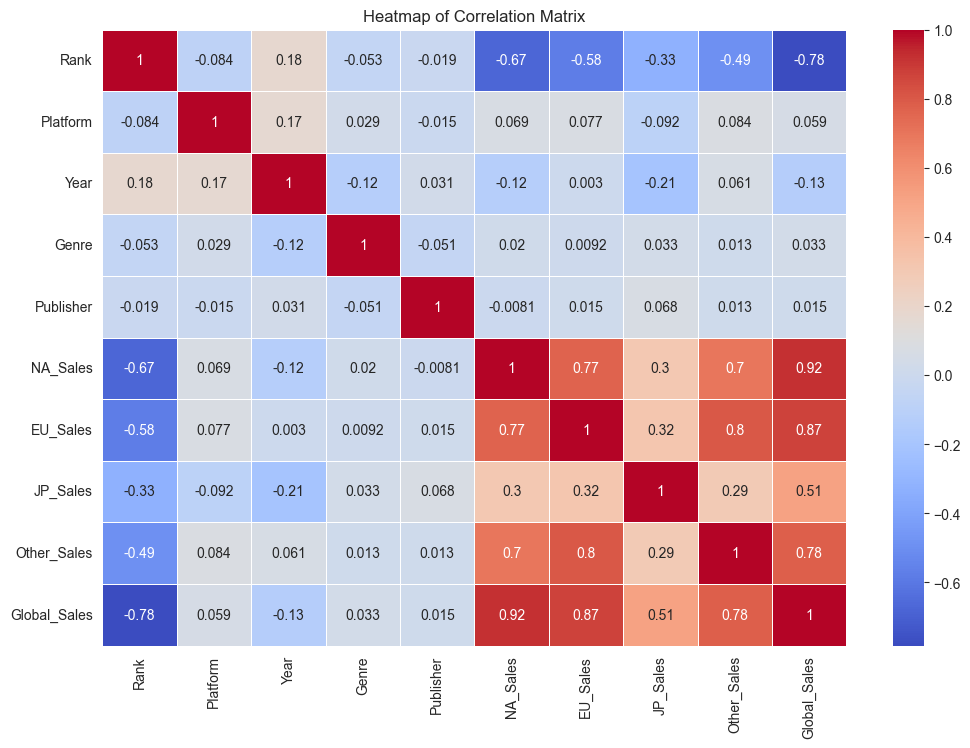

In [44]:
plt.figure(figsize=(12, 8))
correlation_matrix = vgs_transformed.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Correlation Matrix')
plt.show()

## Vy Nguyen


### Linear Regression


In [45]:
selected_features = ['Year','Platform','Genre','Publisher']
X = vgs_transformed[selected_features]
y = video_games_sales["Global_Sales"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")

Mean Squared Error (MSE): 0.1398235217846889
Mean Absolute Error (MAE): 0.2626480105944895
R² Score: 0.022507668563280125


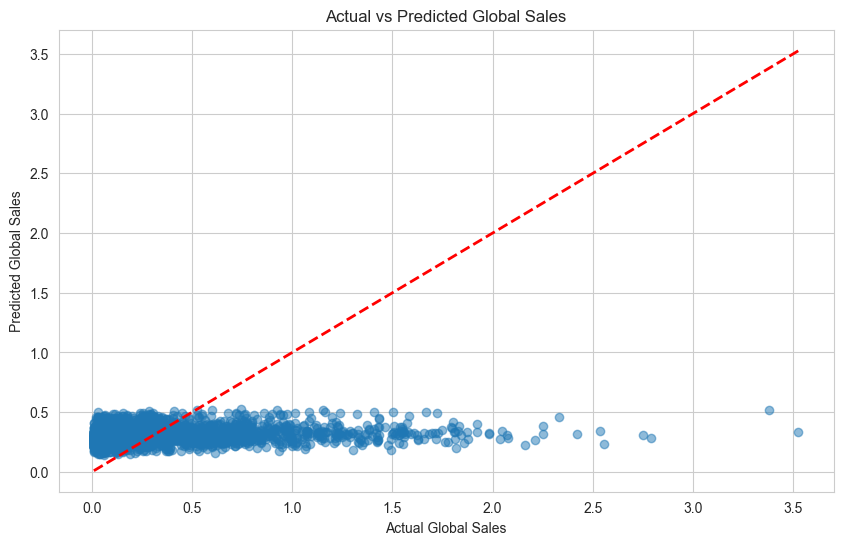

In [46]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Global Sales')
plt.ylabel('Predicted Global Sales')
plt.title('Actual vs Predicted Global Sales')
plt.grid(True)
plt.show()

In [47]:
kf = KFold(n_splits=5, shuffle=True, random_state=12)
mse_scores = []
mae_scores = []
r2_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    mse_scores.append(mean_squared_error(y_test, y_pred))
    mae_scores.append(mean_absolute_error(y_test, y_pred))
    r2_scores.append(r2_score(y_test, y_pred))

print(f"Average Mean Squared Error (MSE): {np.mean(mse_scores)}")
print(f"Average Mean Absolute Error (MAE): {np.mean(mae_scores)}")
print(f"Average R² Score: {np.mean(r2_scores)}")


Average Mean Squared Error (MSE): 0.1531636020241419
Average Mean Absolute Error (MAE): 0.26512505066862857
Average R² Score: 0.022796635602018923


## Clustering


### Hierarchical Clustering


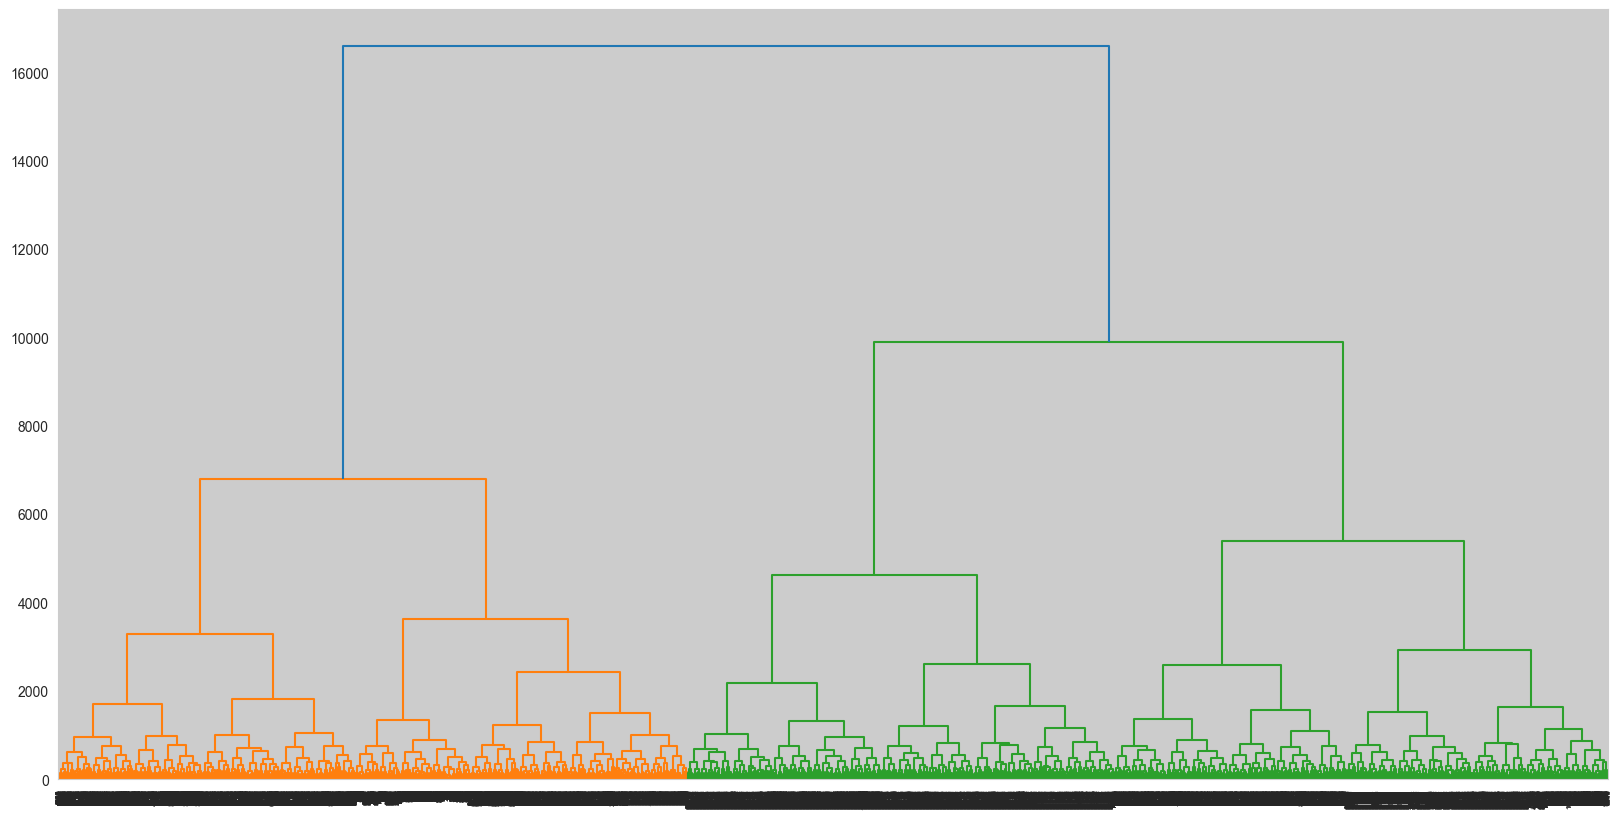

In [48]:
hierarchical_clustering = vgs_transformed
pca = PCA(n_components=2)
hc_pca = pca.fit_transform(hierarchical_clustering)
hc_complete = hierarchy.complete(hc_pca)
fig = plt.figure(figsize=(20, 10))
dn = hierarchy.dendrogram(hc_complete)
plt.show()

Text(0.5, 1.0, 'Silhouette Score vs Number of Clusters')

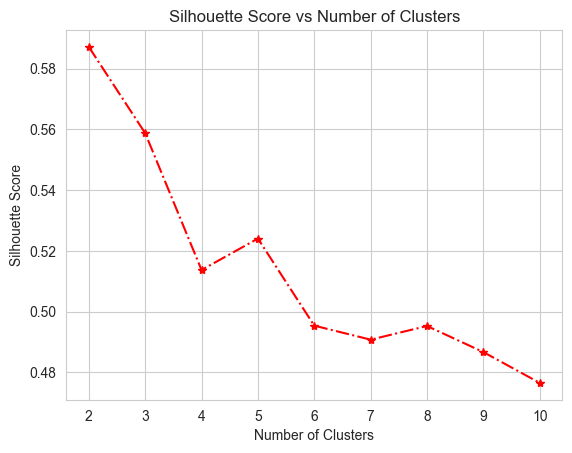

In [49]:
ss= []
k_range=range(2,11)
k_means = [AgglomerativeClustering(n_clusters=k).fit(hierarchical_clustering.values) for k in k_range]
sscores = [silhouette_score(hierarchical_clustering.values, kmean.labels_) for kmean in k_means]

plt.plot(list(k_range), sscores, 'r*-.')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs Number of Clusters")

# K-means Clustering

Clustering shows poor results due to the even distribution of the data.


In [50]:
# Download latest version
data_path = kagglehub.dataset_download("gregorut/videogamesales") + "/vgsales.csv"

# Load the CSV file into a DataFrame
df = pd.read_csv(data_path)

# Forward and backward fill the missing values
df = df.ffill()
df = df.bfill()


DataFrame with Cluster Labels:
   Rank  Platform    Year  Genre  Publisher  NA_Sales  EU_Sales  JP_Sales  \
0     1        26  2006.0     10        359     41.49     29.02      3.77   
1     2        11  1985.0      4        359     29.08      3.58      6.81   
2     3        26  2008.0      6        359     15.85     12.88      3.79   
3     4        26  2009.0     10        359     15.75     11.01      3.28   
4     5         5  1996.0      7        359     11.27      8.89     10.22   

   Other_Sales  Global_Sales  Cluster  
0         8.46         82.74        2  
1         0.77         40.24        2  
2         3.31         35.82        2  
3         2.96         33.00        2  
4         1.00         31.37        2  


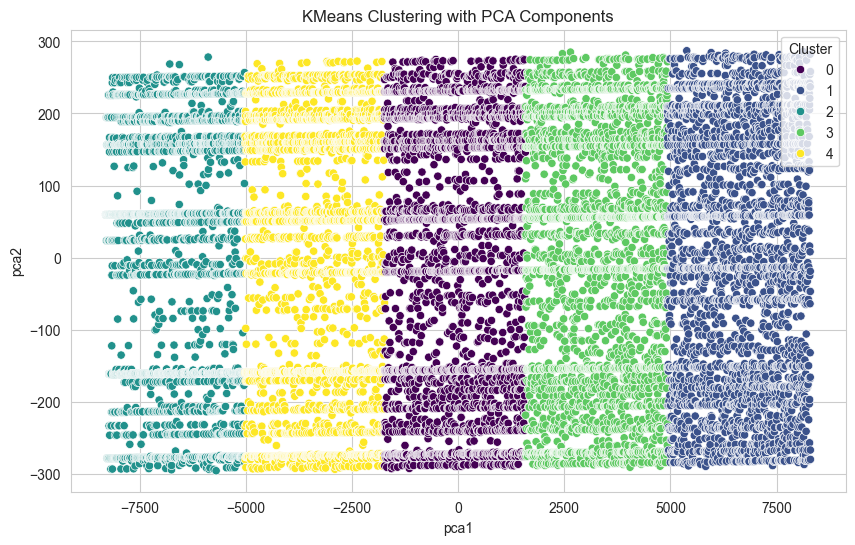

In [51]:
# Create a copy of the DataFrame for numerical encoding
df_num = df.copy()

# Label encode the 'Platform', 'Genre', and 'Publisher' columns
label_encoder = LabelEncoder()
df_num['Platform'] = label_encoder.fit_transform(df['Platform'])
df_num['Genre'] = label_encoder.fit_transform(df['Genre'])
df_num['Publisher'] = label_encoder.fit_transform(df['Publisher'])

# Drop the 'Name' column
df_num.drop(columns=['Name'], inplace=True)

# Perform KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
df_num['Cluster'] = kmeans.fit_predict(df_num)

# Display the first few rows of the DataFrame with cluster labels
print("\nDataFrame with Cluster Labels:")
print(df_num.head())

# Perform PCA for 2D visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(df_num.drop(columns=['Cluster']))
pca_df = pd.DataFrame(data=pca_components, columns=['pca1', 'pca2'])
pca_df['Cluster'] = df_num['Cluster']

# Plot the clustering results
plt.figure(figsize=(10, 6))
sns.scatterplot(x='pca1', y='pca2', hue='Cluster', data=pca_df, palette='viridis')
plt.title('KMeans Clustering with PCA Components')
plt.show()

# Classification Neural Network

Fairly low amount of losses but requires a larger output sizes if we want to predict more rankings. This approach has limited scalability. We will try regression neural network next.

```python
Epoch [100/100], Loss: 8.7682
```


In [61]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

class GameRankingPredictor(nn.Module):
    def __init__(self, input_size, num_classes):
        super(GameRankingPredictor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),  # Replace Softmax with ReLU for hidden layers
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, num_classes)
        )
    
    def forward(self, x):
        return self.network(x)
    
    def predict_proba(self, x):
        # Add softmax to get probability distribution
        return nn.functional.softmax(self.network(x), dim=1)

def train_model(model, X_train, y_train, criterion, optimizer, epochs=100):
    model.train()
    for epoch in range(epochs):
        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print loss every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        _, predicted = torch.max(outputs.data, 1)
        accuracy = (predicted == y_test).float().mean()
        print(f'Test Accuracy: {accuracy.item():.2%}')
        
        # Compute probabilistic predictions
        probabilities = model.predict_proba(X_test)
        return predicted, probabilities

def predict_game_rank(model, game_data, scaler, label_encoder):
    # Prepare and scale the input
    game_tensor = torch.FloatTensor(scaler.transform(game_data.reshape(1, -1)))
    
    # Get prediction with probabilities
    model.eval()
    with torch.no_grad():
        output = model(game_tensor)
        _, predicted_label = torch.max(output, 1)
        probabilities = nn.functional.softmax(output, dim=1)
        
        predicted_rank = label_encoder.inverse_transform(predicted_label.numpy())
    
    return {
        'rank': predicted_rank[0],
        'probabilities': probabilities.numpy()[0]
    }

# Demonstration of how to use the updated model
def main():
    # Assuming df is your DataFrame with the video game data
    features = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Year']
    
    # Prepare features and target
    X = df[features].values
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(df['Rank'])
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    y_train_tensor = torch.LongTensor(y_train)
    X_test_tensor = torch.FloatTensor(X_test_scaled)
    y_test_tensor = torch.LongTensor(y_test)
    
    # Determine number of unique classes
    num_classes = len(np.unique(y))
    
    # Instantiate the model
    model = GameRankingPredictor(input_size=len(features), num_classes=num_classes)
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Train the model
    train_model(model, X_train_tensor, y_train_tensor, criterion, optimizer)
    
    # Evaluate and get predictions with probabilities
    predictions, probabilities = evaluate_model(model, X_test_tensor, y_test_tensor)
    
    # Example: Predicting rank for a hypothetical new game
    new_game_features = np.array([20.0, 15.0, 5.0, 2.0, 42.0, 2010.0])
    result = predict_game_rank(model, new_game_features, scaler, label_encoder)
    
    print(f"Predicted Rank for New Game: {result['rank']}")
    print("Rank Probabilities:", result['probabilities'])

if __name__ == '__main__':
    main()

Epoch [10/100], Loss: 9.7147
Epoch [20/100], Loss: 9.6965
Epoch [30/100], Loss: 9.6598
Epoch [40/100], Loss: 9.5908
Epoch [50/100], Loss: 9.4833
Epoch [60/100], Loss: 9.3385
Epoch [70/100], Loss: 9.1820
Epoch [80/100], Loss: 9.0238
Epoch [90/100], Loss: 8.8800
Epoch [100/100], Loss: 8.7499
Test Accuracy: 0.00%
Predicted Rank for New Game: 38
Rank Probabilities: [1.6220030e-41 9.3242377e-02 1.0162645e-01 ... 6.2203235e-37 7.1263915e-36
 2.1344266e-33]


# Regression Neural Network without Feature Selection

High loss and high mean absolute error.

```python
Training Loss: 92026328.0000
Validation Loss: 90543288.0000
Mean Absolute Error: 8239.3281
```


In [53]:
# Data Preprocessing
def preprocess_data(df):
    # Select relevant features
    features = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Year']
    
    # Create a copy of the dataframe
    processed_df = df.copy()
    
    # Handle missing values
    imputer = SimpleImputer(strategy='median')
    
    # Select features
    X = processed_df[features].values
    
    # Impute missing values
    X = imputer.fit_transform(X)
    
    # Normalize features
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Prepare target (Rank)
    y = processed_df['Rank'].values
    
    return X_scaled, y, scaler

# Prepare the data
X_scaled, y, scaler = preprocess_data(df)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)

# Advanced Neural Network for Regression
class RankPredictor(nn.Module):
    def __init__(self, input_size):
        super(RankPredictor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.network(x)

# Instantiate the model
model = RankPredictor(input_size=X_train.shape[1])

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, X_train, y_train, X_test, y_test, criterion, optimizer, epochs=200):
    # Move tensors to appropriate device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    X_train, y_train = X_train.to(device), y_train.to(device)
    X_test, y_test = X_test.to(device), y_test.to(device)
    
    # Training mode
    model.train()
    
    for epoch in range(epochs):
        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Validation
        if (epoch + 1) % 200 == 0:
            model.eval()
            with torch.no_grad():
                val_outputs = model(X_test)
                val_loss = criterion(val_outputs, y_test)
                
                # Calculate Mean Absolute Error
                mae = torch.mean(torch.abs(val_outputs - y_test))
                
                print(f'Epoch [{epoch+1}/{epochs}]')
                print(f'Training Loss: {loss.item():.4f}')
                print(f'Validation Loss: {val_loss.item():.4f}')
                print(f'Mean Absolute Error: {mae.item():.4f}\n')
            
            model.train()

# Train the model
train_model(model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, criterion, optimizer)

# Prediction function
def predict_game_rank(model, game_data, scaler):
    # Prepare and scale the input
    game_scaled = scaler.transform(game_data.reshape(1, -1))
    game_tensor = torch.FloatTensor(game_scaled)
    
    # Get prediction
    model.eval()
    with torch.no_grad():
        predicted_rank = model(game_tensor)
    
    return predicted_rank.item()

# Example prediction
new_game_features = np.array([20.0, 15.0, 5.0, 2.0, 42.0, 2010.0])
predicted_rank = predict_game_rank(model, new_game_features, scaler)
print(f"Predicted Rank for New Game: {predicted_rank}")

# Additional model evaluation
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor)
    # Calculate R-squared (coefficient of determination)
    ss_total = torch.sum((y_test_tensor - torch.mean(y_test_tensor)) ** 2)
    ss_residual = torch.sum((y_test_tensor - test_predictions) ** 2)
    r_squared = 1 - (ss_residual / ss_total)
    print(f"R-squared: {r_squared.item():.4f}")

Epoch [200/200]
Training Loss: 92044352.0000
Validation Loss: 90537312.0000
Mean Absolute Error: 8239.1074

Predicted Rank for New Game: -15.88207721710205
R-squared: -2.9907


# Regression Neural Network with Feature Selection and RobustScaler for handling outliers

Low loss and low mean absolute error.

```python
Train Loss: 0.0154
Validation Loss: 0.0221

Mean Squared Error: 0.0226
Mean Absolute Error: 0.0471
```


Feature Importance:
        feature      f_score
0  Global_Sales  3709.299117
1      NA_Sales  3186.852398
2      EU_Sales  2785.841300
3   Other_Sales  2069.646067
4      JP_Sales  1282.007227
5          Year   543.200714


/Users/jamievuong/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 299:
Train Loss: 0.0241
Validation Loss: 0.0098


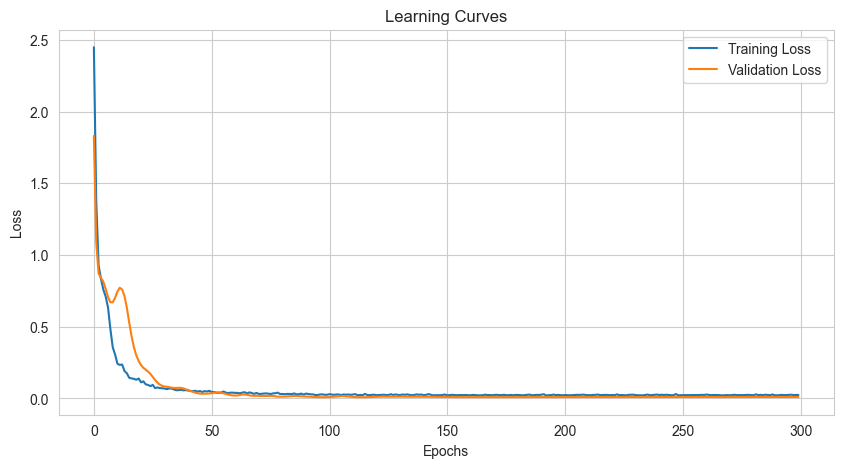

Mean Squared Error: 0.0098
Mean Absolute Error: 0.0498
Selected Features: ['Global_Sales', 'NA_Sales', 'EU_Sales']


In [54]:
# Comprehensive data preprocessing
def preprocess_data(df):
    # Select relevant features
    features = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Year']
    target = 'Rank'
    
    # Remove rows with missing critical data
    df_cleaned = df.dropna(subset=features + [target])
    
    # Extract features and target
    X = df_cleaned[features].values
    y = df_cleaned[target].values
    
    # Perform feature importance analysis
    f_scores, _ = f_regression(X, y)
    feature_importance = pd.DataFrame({
        'feature': features,
        'f_score': f_scores
    }).sort_values('f_score', ascending=False).reset_index(drop=True)
    
    print("Feature Importance:")
    print(feature_importance)
    
    # Select most important features
    top_features = feature_importance['feature'].head(3).tolist()
    X = df_cleaned[top_features].values
    
    # Scale features using RobustScaler to handle outliers
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Normalize target variable
    target_scaler = StandardScaler()
    y_scaled = target_scaler.fit_transform(y.reshape(-1, 1)).flatten()
    
    return X_scaled, y_scaled, scaler, target_scaler, top_features

# Advanced Neural Network with Residual Connections
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(in_features, in_features),
            nn.BatchNorm1d(in_features),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features, in_features)
        )
        self.relu = nn.ReLU()
    
    def forward(self, x):
        residual = x
        out = self.block(x)
        out += residual
        return self.relu(out)

class RankPredictor(nn.Module):
    def __init__(self, input_size):
        super(RankPredictor, self).__init__()
        self.input_layer = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )
        
        # Residual blocks
        self.residual_blocks = nn.ModuleList([
            ResidualBlock(64) for _ in range(3)
        ])
        
        self.output_layer = nn.Linear(64, 1)
    
    def forward(self, x):
        x = self.input_layer(x)
        for block in self.residual_blocks:
            x = block(x)
        return self.output_layer(x)

# Training and evaluation function with advanced logging
def train_and_evaluate(X, y, test_size=0.2, random_state=42):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    # Convert to tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)
    
    # Initialize model, loss, and optimizer
    model = RankPredictor(input_size=X_train.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 'min', patience=10, factor=0.5, verbose=True
    )
    
    # Training loop with detailed logging
    train_losses = []
    val_losses = []
    
    for epoch in range(300):
        # Training phase
        model.train()
        optimizer.zero_grad()
        train_outputs = model(X_train_tensor)
        train_loss = criterion(train_outputs, y_train_tensor)
        train_loss.backward()
        optimizer.step()
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_test_tensor)
            val_loss = criterion(val_outputs, y_test_tensor)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Store losses
        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())
        
        # Periodic logging
        if epoch == 299:
            print(f'Epoch {epoch}:')
            print(f'Train Loss: {train_loss.item():.4f}')
            print(f'Validation Loss: {val_loss.item():.4f}')
    
    # Visualize learning curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Learning Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Model evaluation
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor)
        mse = torch.nn.functional.mse_loss(predictions, y_test_tensor)
        mae = torch.mean(torch.abs(predictions - y_test_tensor))
        print(f'Mean Squared Error: {mse.item():.4f}')
        print(f'Mean Absolute Error: {mae.item():.4f}')
    
    return model

# Main execution
# Preprocess data
X_scaled, y_scaled, feature_scaler, target_scaler, selected_features = preprocess_data(df)

# Train and evaluate the model
best_model = train_and_evaluate(X_scaled, y_scaled)

# Prediction function
def predict_game_rank(model, game_data, feature_scaler, target_scaler, selected_features):
    # Ensure input matches selected features
    game_scaled = feature_scaler.transform(game_data.reshape(1, -1))
    game_tensor = torch.FloatTensor(game_scaled)
    
    model.eval()
    with torch.no_grad():
        predicted_scaled = model(game_tensor)
        # Inverse transform to get original scale
        predicted_rank = target_scaler.inverse_transform(predicted_scaled.numpy())[0][0]
    
    return predicted_rank

# Example prediction
new_game_features = df[selected_features].values[0]  # Use existing game's features as an example
predicted_rank = predict_game_rank(best_model, new_game_features, feature_scaler, target_scaler, selected_features)
# print(f"\nPredicted Rank: {predicted_rank}")
print(f"Selected Features: {selected_features}")

# Regression Neural Network with Feature Selection with MinMaxScaler

Low loss and low mean absolute error.

```python
Train Loss: 0.0014
Validation Loss: 0.0007

Mean Squared Error: 0.0016
Mean Absolute Error: 0.0280
```


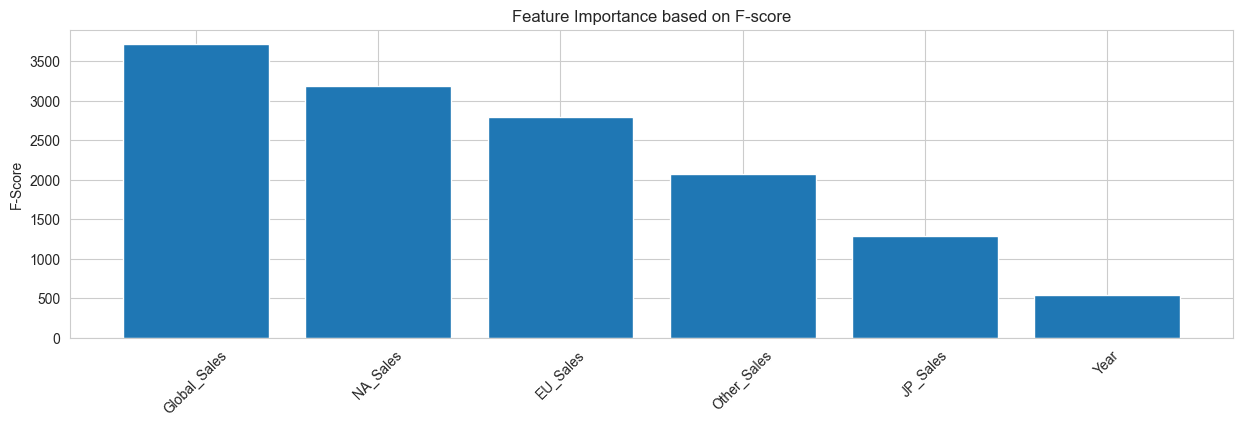

Feature Importance:
        feature      f_score
0  Global_Sales  3709.299117
1      NA_Sales  3186.852398
2      EU_Sales  2785.841300
3   Other_Sales  2069.646067
4      JP_Sales  1282.007227
5          Year   543.200714


/Users/jamievuong/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


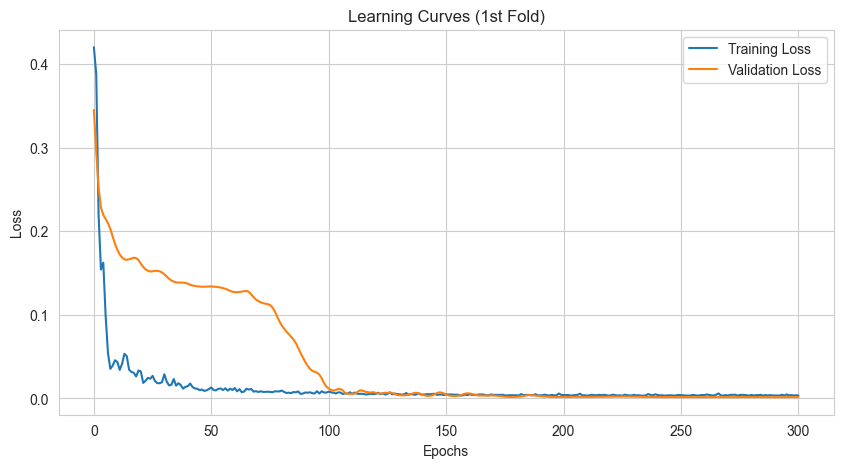

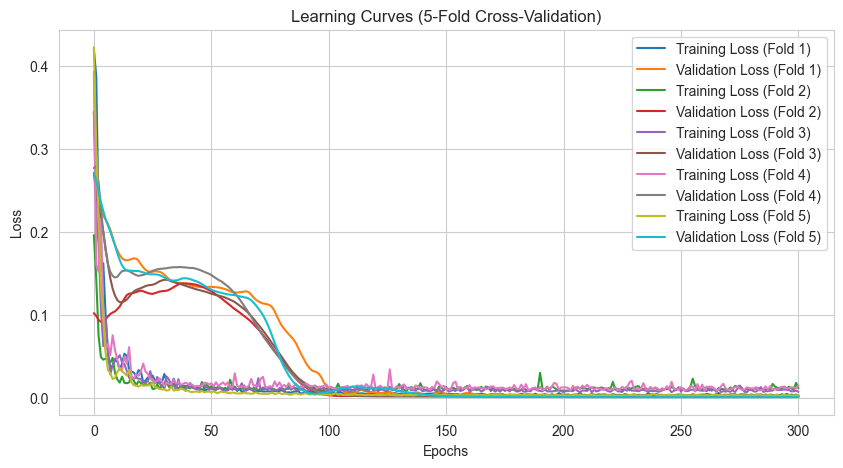

Train Loss: 0.0033
Validation Loss: 0.0015


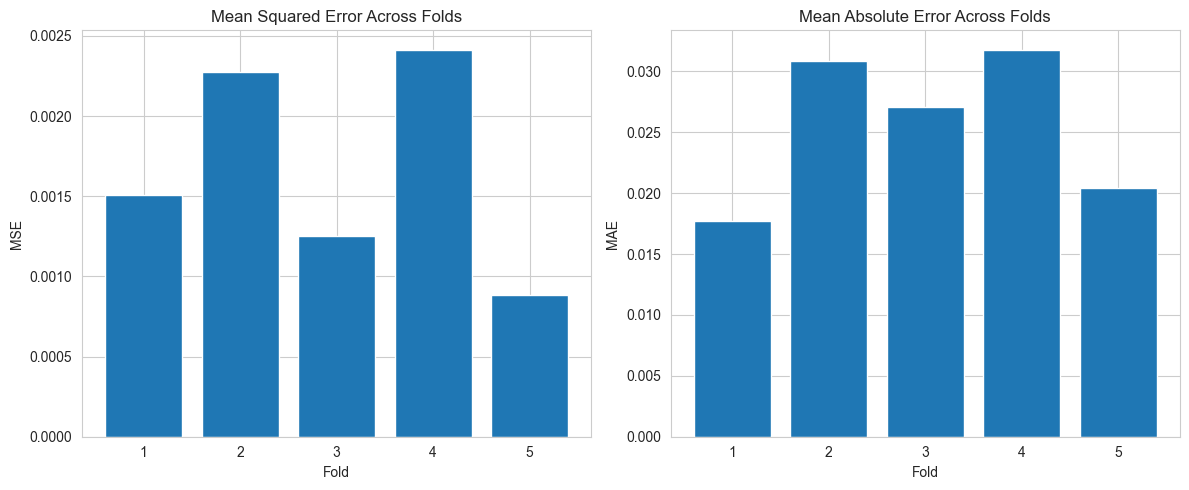

Mean Squared Error: 0.0009
Mean Absolute Error: 0.0204

Prediction Details:
Sample Game Features: [82.74 41.49 29.02]


In [55]:
# Comprehensive data preprocessing
def preprocess_data(df):
    # Select relevant features
    features = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Year']
    target = 'Rank'
    
    # Remove rows with missing critical data
    df_cleaned = df.dropna(subset=features + [target])
    
    # Extract features and target
    X = df_cleaned[features].values
    y = df_cleaned[target].values
    
    # Perform feature importance analysis
    f_scores, _ = f_regression(X, y)
    feature_importance = pd.DataFrame({
        'feature': features,
        'f_score': f_scores
    }).sort_values('f_score', ascending=False).reset_index(drop=True)
    
    # Plot the feature importance
    plt.figure(figsize=(15, 4))
    plt.bar(feature_importance['feature'], feature_importance['f_score'])
    plt.title('Feature Importance based on F-score')
    plt.xticks(rotation=45)
    plt.ylabel('F-Score')
    plt.show()

    print("Feature Importance:")
    print(feature_importance)

    # Select most important features
    top_features = feature_importance['feature'].head(3).tolist()
    X = df_cleaned[top_features].values

    # Scale features
    feature_scaler = MinMaxScaler()
    X_scaled = feature_scaler.fit_transform(X)
    
    # For the target, use a different approach
    # Instead of scaling, we'll normalize relative to the dataset
    y_min = y.min()
    y_max = y.max()
    y_normalized = (y - y_min) / (y_max - y_min)
    
    return X_scaled, y_normalized, feature_scaler, y_min, y_max

# Advanced Neural Network with Residual Connections
# ... (code for ResidualBlock and RankPredictor models remains the same)

# Training and evaluation function with 5-fold cross-validation
def train_and_evaluate(X, y, random_state=42):
    # Initialize 5-fold cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=random_state)
    
    # Initialize lists to store losses
    train_losses = []
    val_losses = []
    mse_scores = []
    mae_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X), 1):
        # Split the data for the current fold
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Convert to tensors
        X_train_tensor = torch.FloatTensor(X_train)
        y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)
        X_val_tensor = torch.FloatTensor(X_val)
        y_val_tensor = torch.FloatTensor(y_val).unsqueeze(1)
        
        # Initialize model, loss, and optimizer
        model = RankPredictor(input_size=X_train.shape[1])
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
        
        # Learning rate scheduler
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 'min', patience=10, factor=0.5, verbose=True
        )
        
        # Training loop with detailed logging
        fold_train_losses = []
        fold_val_losses = []
        
        for epoch in range(301):
            # Training phase
            model.train()
            optimizer.zero_grad()
            train_outputs = model(X_train_tensor)
            train_loss = criterion(train_outputs, y_train_tensor)
            train_loss.backward()
            optimizer.step()
            
            # Validation phase
            model.eval()
            with torch.no_grad():
                val_outputs = model(X_val_tensor)
                val_loss = criterion(val_outputs, y_val_tensor)
            
            # Learning rate scheduling
            scheduler.step(val_loss)
            
            # Store losses
            fold_train_losses.append(train_loss.item())
            fold_val_losses.append(val_loss.item())

        # Append fold-specific losses to the overall lists
        train_losses.append(fold_train_losses)
        val_losses.append(fold_val_losses)
        
        # Model evaluation (use the last fold)
        model.eval()
        with torch.no_grad():
            predictions = model(X_val_tensor)
            mse = torch.nn.functional.mse_loss(predictions, y_val_tensor)
            mae = torch.mean(torch.abs(predictions - y_val_tensor))
            mse_scores.append(mse.item())
            mae_scores.append(mae.item())
        

    # Visualize learning curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses[0], label='Training Loss')
    plt.plot(val_losses[0], label='Validation Loss')
    plt.title('Learning Curves (1st Fold)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Visualize learning curves
    plt.figure(figsize=(10, 5))
    for i in range(5):
        plt.plot(train_losses[i], label=f'Training Loss (Fold {i+1})')
        plt.plot(val_losses[i], label=f'Validation Loss (Fold {i+1})')
    plt.title('Learning Curves (5-Fold Cross-Validation)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    print(f'Train Loss: {train_losses[0][-1]:.4f}')
    print(f'Validation Loss: {val_losses[0][-1]:.4f}')

    # Plotting MSE and MAE across folds
    plt.figure(figsize=(12, 5))
    
    # MSE Plot
    plt.subplot(1, 2, 1)
    plt.bar(range(1, 6), mse_scores)
    plt.title('Mean Squared Error Across Folds')
    plt.xlabel('Fold')
    plt.ylabel('MSE')
    plt.xticks(range(1, 6))
    
    # MAE Plot
    plt.subplot(1, 2, 2)
    plt.bar(range(1, 6), mae_scores)
    plt.title('Mean Absolute Error Across Folds')
    plt.xlabel('Fold')
    plt.ylabel('MAE')
    plt.xticks(range(1, 6))
    
    plt.tight_layout()
    plt.show()

    print(f'Mean Squared Error: {mse_scores[-1]:.4f}')
    print(f'Mean Absolute Error: {mae_scores[-1]:.4f}')

    return model

# Main execution
# Preprocess data
X_scaled, y_normalized, feature_scaler, y_min, y_max = preprocess_data(df)

# Train and evaluate the model using 5-fold cross-validation
best_model = train_and_evaluate(X_scaled, y_normalized)

# Prediction function (unchanged)
def predict_game_rank(model, game_data, feature_scaler, y_min, y_max):
    # Scale the input features
    game_scaled = feature_scaler.transform(game_data.reshape(1, -1))
    game_tensor = torch.FloatTensor(game_scaled)
    
    model.eval()
    with torch.no_grad():
        # Get normalized prediction
        predicted_normalized = model(game_tensor).item()
        
        # Denormalize to original rank scale
        predicted_rank = predicted_normalized * (y_max - y_min) + y_min
    
    return predicted_rank

# Example prediction (unchanged)
sample_game = df[['Global_Sales', 'NA_Sales', 'EU_Sales']].iloc[0].values
predicted_rank = predict_game_rank(best_model, sample_game, feature_scaler, y_min, y_max)

print("\nPrediction Details:")
print(f"Sample Game Features: {sample_game}")
# print(f"Predicted Rank: {predicted_rank}")
# print(f"Actual Rank: {df.iloc[0]['Rank']}")